In [1]:
from sklearn.datasets import load_files
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report,precision_recall_curve
from sklearn.preprocessing import normalize,maxabs_scale,robust_scale,StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc,roc_auc_score,precision_recall_curve
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV,train_test_split,StratifiedKFold,cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier

from scipy import stats
from scipy import interp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import *

# Préparation des données

In [2]:
media_test = pd.read_csv('media.test.csv2',header=None,sep='\t')
media_test = media_test.rename(columns = {3 : 'ac_nc'})

In [3]:
temp = pd.DataFrame(index=range(media_test.shape[0]),columns = range(len(media_test.iloc[5,2].split(" "))-1))
temp  
for i in range(media_test.shape[0]):
    if not isinstance(media_test.iloc[i,2], float):
         temp.iloc[i,:] = media_test.iloc[i,2].split(" ")[:-1]

media_test = pd.concat([media_test.iloc[:,0:2],temp,media_test['ac_nc']],axis = 1)
#Passage au float 
for i in range(4,105):
    media_test.iloc[:,i] = pd.to_numeric(media_test.iloc[:,i], downcast="float")

media_test = media_test.dropna(axis = 0)
media_test = media_test.set_index(np.arange(len(media_test.index)))

In [4]:
media_test

0          1                     0                     1  \
0             je         je       B-command-tache       B-command-tache   
1       voudrais   voudrais       I-command-tache       I-command-tache   
2       réserver   réserver       I-command-tache       I-command-tache   
3           pour       pour          B-rang-temps          B-rang-temps   
4             le         le          I-rang-temps          I-rang-temps   
...          ...        ...                   ...                   ...   
25972  connexion  connexion  I-chambre-equipement  I-chambre-equipement   
25973   internet      EQUIP  I-chambre-equipement  I-chambre-equipement   
25974        oui        oui             B-reponse             B-reponse   
25975        non        non             B-reponse             B-reponse   
25976      merci      merci                     O                     O   

              2            3            4            5            6  \
0      0.998018    0.0301482  0.000228925      0.95256       0.1821   
1      0.999604    0.0073296  0.000770102      0.85728     0.179354   
2      0.999715   0.00572529  0.000175758     0.960663     0.287657   
3      0.996765     0.973825    0.0532127    0.0382341     0.963447   
4      0.993861     0.990773  0.000549251    0.0560375  6.60816e-05   
...         ...          ...          ...          ...          ...   
25972  0.997337     0.999366     0.958398   0.00717638  0.000711134   
25973  0.998073     0.999054     0.631952   0.00793344  0.000436496   
25974  0.999201  0.000383502  0.000792989     0.979959      0.99991   
25975  0.999327  0.000378273  0.000161412     0.985691     0.997319   
25976  0.999999     0.687728     0.997026  0.000145167     0.999192   

                 7  ...           94           95           96           97  \
0        0.0480406  ...     0.813737  0.000333157  0.000366783  0.000233999   
1         0.631231  ...      0.83518     0.995363  0.000259368  2.41359e-07   
2         0.926826  ...      0.97941     0.986365  0.000136052  2.90215e-06   
3         0.015918  ...     0.265613     0.887438  1.70981e-06  0.000461083   
4         0.708674  ...     0.941017     0.956745  4.16158e-06  1.56448e-06   
...            ...  ...          ...          ...          ...          ...   
25972    0.0035486  ...        0.802    0.0440583  1.80593e-05  2.92048e-05   
25973  0.000958828  ...     0.858877   0.00202038  1.44854e-05  2.24003e-05   
25974  4.38209e-05  ...  0.000511339  5.48497e-05  1.68043e-05     0.313139   
25975  0.000293395  ...   0.00417137  1.66618e-05  3.08434e-05     0.660996   
25976  0.000201005  ...  5.30048e-05     0.475639  1.69593e-05  9.62638e-05   

                98           99          100          101          102 ac_nc  
0         0.985451  4.95932e-05  6.24909e-05     0.231074  2.02805e-05    AC  
1          0.99212  5.81254e-06  6.22006e-05   0.00100287  0.000151936    AC  
2         0.999223  1.49754e-05  1.14268e-05  5.52364e-05  4.52373e-05    AC  
3         0.935826  1.94494e-05  0.000271944   0.00582158   0.00127766    AC  
4         0.753173   6.4256e-06  0.000186329  0.000904377   0.00360909    AC  
...            ...          ...          ...          ...          ...   ...  
25972    0.0022361  3.73248e-06      0.97818     0.905776     0.999124    AC  
25973  0.000472328  4.81788e-06     0.708476     0.653963     0.996315    NC  
25974     0.921367  1.13104e-05      0.99984      0.99986   0.00013701    AC  
25975     0.970992  2.22921e-05     0.982955     0.983058  9.19438e-05    AC  
25976    0.0181047  5.35363e-06     0.965527     0.999829      0.99079    AC  

[25977 rows x 106 columns]

In [5]:
media_train = pd.read_csv('media.train.csv',header=None,sep='\t')
temp = pd.DataFrame(index=range(media_train.shape[0]),columns = range(len(media_train.iloc[1,2].split(" "))-1))    
for i in range(media_train.shape[0]):
    if not isinstance(media_train.iloc[i,0], float):
         temp.iloc[i,:] = media_train.iloc[i,2].split(" ")[:-1]
media_train = pd.concat([temp],axis=1)

#Passage au float 
for i in range(3,103):
    media_train.iloc[:,i] = pd.to_numeric(media_train.iloc[:,i], downcast="float")

media_train = media_train.dropna(axis = 0)
media_train = media_train.set_index(np.arange(len(media_train.index)))

In [6]:
media_train

0                1           2         3         4    \
0                    O                O   0.9984357  0.141061  0.500814   
1                    O                O    0.999998  0.415609  0.999754   
2                    O                O   0.9999938  0.535512  0.971521   
3                    O                O   0.9999604  0.288770  0.930845   
4      B-command-tache  B-command-tache  0.97180015  0.018397  0.001405   
...                ...              ...         ...       ...       ...   
95845                O                O  0.99526334  0.035269  0.476390   
95846  B-command-tache  B-command-tache   0.9931213  0.039003  0.000483   
95847  I-command-tache  I-command-tache  0.99973506  0.001199  0.000013   
95848                O                O   0.9999993  0.414680  0.996906   
95849                O                O   0.9999999  0.926874  0.999923   

            5         6         7         8         9    ...       93   \
0      0.006298  0.999117  0.000025  0.754290  0.927000  ...  0.995232   
1      0.000009  0.997908  0.000240  0.000793  0.998986  ...  0.999934   
2      0.005283  0.999870  0.000256  0.057462  0.992019  ...  0.980662   
3      0.001649  0.998764  0.015108  0.000063  0.999819  ...  0.969404   
4      0.809108  0.009147  0.182557  0.016848  0.985176  ...  0.000028   
...         ...       ...       ...       ...       ...  ...       ...   
95845  0.075374  0.951898  0.033341  0.005141  0.943043  ...  0.209970   
95846  0.978675  0.276699  0.460933  0.000027  0.988326  ...  0.000002   
95847  0.985957  0.842092  0.986814  0.000002  0.999090  ...  0.000002   
95848  0.000243  0.990119  0.000702  0.868323  0.989494  ...  0.998248   
95849  0.000004  0.996899  0.000924  0.062012  0.999670  ...  0.999994   

            94        95        96            97        98        99   \
0      0.143684  0.036528  0.000005  4.142131e-02  0.520406  0.000034   
1      0.125917  0.997854  0.000052  5.635835e-05  0.208605  0.000054   
2      0.004338  0.082868  0.000058  3.408458e-03  0.006579  0.000022   
3      0.003168  0.999938  0.000014  4.533151e-07  0.052859  0.000001   
4      0.854648  0.003358  0.001263  2.128996e-05  0.960108  0.000087   
...         ...       ...       ...           ...       ...       ...   
95845  0.008822  0.088434  0.000052  1.573645e-05  0.713457  0.000013   
95846  0.805495  0.002580  0.001215  2.870929e-04  0.994831  0.000098   
95847  0.977844  0.994881  0.000165  2.119563e-06  0.999220  0.000009   
95848  0.002686  0.489957  0.000040  1.281848e-03  0.001709  0.000033   
95849  0.002554  0.641883  0.000027  4.383378e-05  0.072571  0.000082   

            100       101       102  
0      0.988428  0.832955  0.009497  
1      0.997766  0.997710  0.728009  
2      0.954000  0.998321  0.821338  
3      0.928032  0.505498  0.938585  
4      0.000043  0.066663  0.000360  
...         ...       ...       ...  
95845  0.006116  0.968557  0.007992  
95846  0.000026  0.073869  0.000046  
95847  0.000015  0.000004  0.000093  
95848  0.993213  0.998733  0.919537  
95849  0.997481  0.999994  0.997544  

[95850 rows x 103 columns]

# Qualité des prédictions

## Mesures

In [7]:
true_classes = [1 if media_test.iloc[i,2]==media_test.iloc[i,3] else 0 for i in range(len(media_test.index))]

In [8]:
print(classification_report(media_test.iloc[:,2],media_test.iloc[:,3]))

/Users/malotanne/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                    precision    recall  f1-score   support

              B-chambre-equipement       0.83      0.73      0.78        98
                  B-chambre-fumeur       0.48      0.53      0.50        19
                B-chambre-standing       0.60      0.43      0.50         7
                    B-chambre-type       0.96      0.98      0.97       242
                 B-chambre-voisine       0.81      0.85      0.83        20
                    B-command-dial       0.88      0.64      0.74        69
                   B-command-tache       0.89      0.84      0.86       548
                      B-comparatif       0.00      0.00      0.00         2
             B-comparatif-paiement       0.80      0.80      0.80       202
                B-comparatif-temps       1.00      0.20      0.33         5
                     B-connectAttr       0.63      0.92      0.75        24
                     B-connectProp       0.75      0.80      0.77       348
           

## Courbe ROC

AUC RNN = 0.8440


Text(0, 0.5, 'True positive rate')

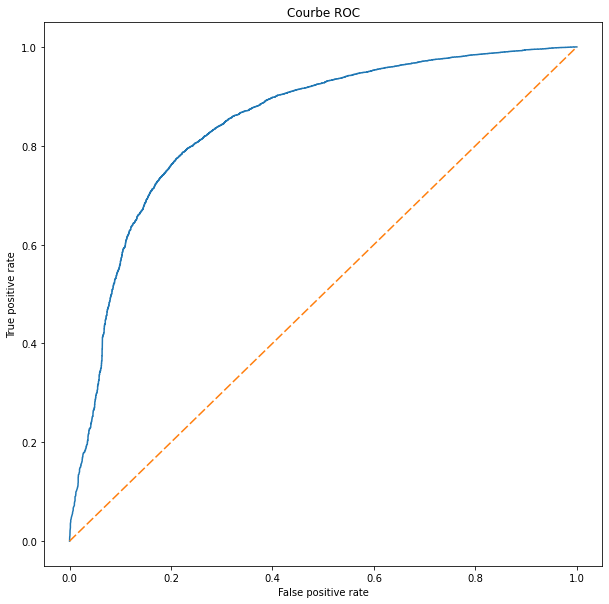

In [9]:
fpr, tpr, thresholds = metrics.roc_curve(true_classes, media_test.iloc[:,4],pos_label=1)
print('AUC RNN = {:.4f}'.format(roc_auc_score(true_classes, media_test.iloc[:,4])))
figure = plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot(np.arange(0,1.02,0.02),np.arange(0,1.02,0.02), dashes=[6, 2])
title = 'Courbe ROC'
plt.title(title) 
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

## Courbe Précision-Rappel

AUC RNN = 0.8440


Text(0, 0.5, 'Précision')

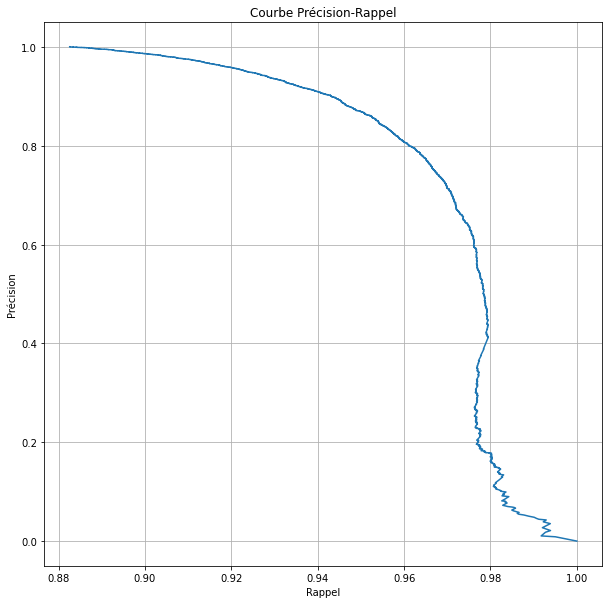

In [10]:
fpr, tpr, thresholds = metrics.precision_recall_curve(true_classes, media_test.iloc[:,4],pos_label=1)
print('AUC RNN = {:.4f}'.format(roc_auc_score(true_classes, media_test.iloc[:,4])))
figure = plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
title = 'Courbe Précision-Rappel'
plt.title(title) 
plt.xlabel('Rappel')
plt.grid()
plt.ylabel('Précision')

# Recherche des Clusters avec les densités

##### Les histogrammes sur lesquels on va inférer nos densités

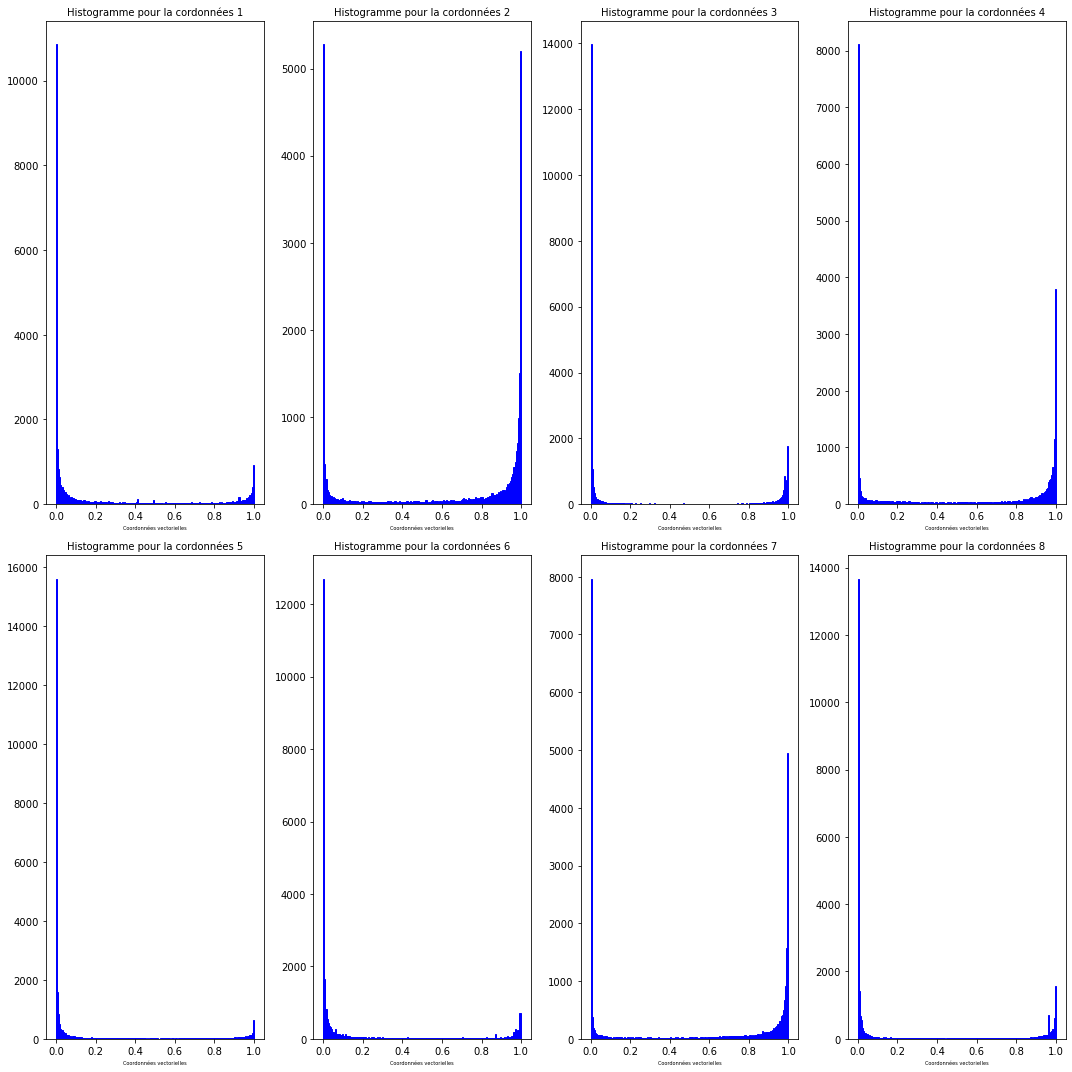

In [11]:
fig, ax = plt.subplots(figsize=(15,15))
for i in range(5,13):
    
    # Set up the plot
    ax = plt.subplot(2, 4, i-4)
    
    # Draw the plot
    ax.hist(media_test.iloc[:,i], bins = 180,
             color = 'blue', edgecolor = 'blue')
    
    # Title and labels
    ax.set_title('Histogramme pour la cordonnées %d' % (i-4), size = 10)
    ax.set_xlabel('Coordonnées vectorielles', size = 5)

plt.tight_layout()
plt.show()

##### Et donc les densités estimées

Text(0.5, 1.0, 'Coordonées 8')

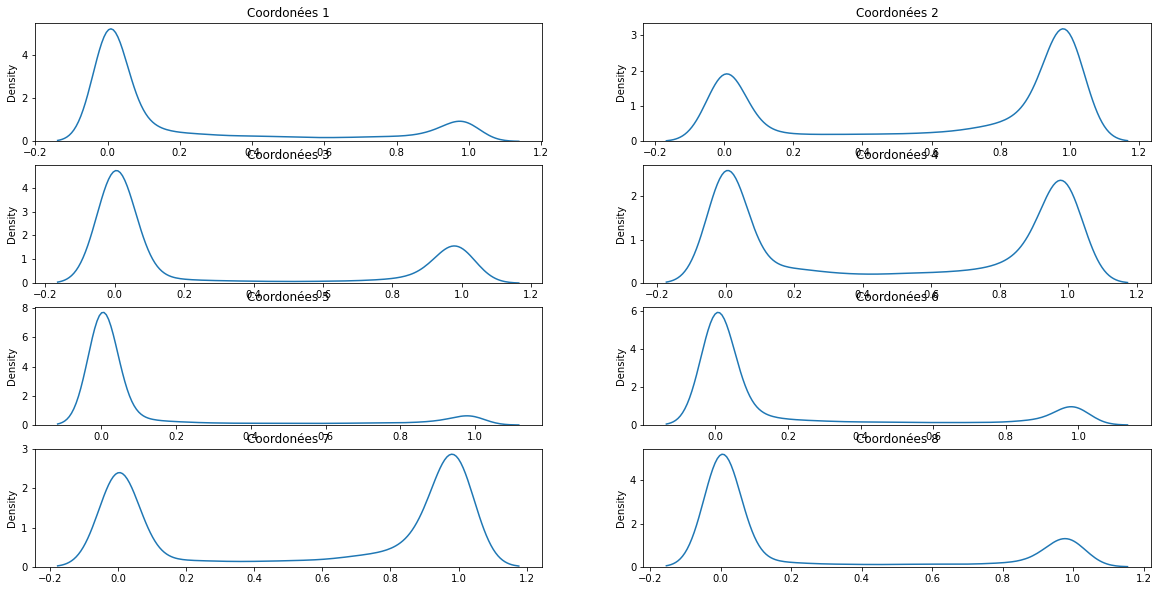

In [12]:
fig, axes = plt.subplots(figsize=(20,10), ncols=2, nrows=4)
sns.kdeplot(np.array(media_test.iloc[:,5],dtype = 'float'), ax=axes[0,0]).set_title('Coordonées 1')
sns.kdeplot(np.array(media_test.iloc[:,6],dtype = 'float'), ax=axes[0,1]).set_title('Coordonées 2')
sns.kdeplot(np.array(media_test.iloc[:,7],dtype = 'float'), ax=axes[1,0]).set_title('Coordonées 3')
sns.kdeplot(np.array(media_test.iloc[:,8],dtype = 'float'), ax=axes[1,1]).set_title('Coordonées 4')
sns.kdeplot(np.array(media_test.iloc[:,9],dtype = 'float'), ax=axes[2,0]).set_title('Coordonées 5')
sns.kdeplot(np.array(media_test.iloc[:,10],dtype = 'float'), ax=axes[2,1]).set_title('Coordonées 6')
sns.kdeplot(np.array(media_test.iloc[:,11],dtype = 'float'), ax=axes[3,0]).set_title('Coordonées 7')
sns.kdeplot(np.array(media_test.iloc[:,12],dtype = 'float'), ax=axes[3,1]).set_title('Coordonées 8')

##### On va rajouter 100 composantes pour aider le classifieur à trouver les clusters, ces 100 valeurs sont les valeurs des densités pour chaque composante.

In [13]:
X_train = np.array(media_train.iloc[:,5:105])
X_train

array([[6.2976801e-03, 9.9911720e-01, 2.4550760e-05, ..., 9.8842818e-01,
        8.3295542e-01, 9.4973017e-03],
       [8.6851123e-06, 9.9790800e-01, 2.3993677e-04, ..., 9.9776638e-01,
        9.9770975e-01, 7.2800899e-01],
       [5.2825138e-03, 9.9987006e-01, 2.5644540e-04, ..., 9.5399982e-01,
        9.9832135e-01, 8.2133782e-01],
       ...,
       [9.8595691e-01, 8.4209239e-01, 9.8681426e-01, ..., 1.4904415e-05,
        3.7097427e-06, 9.3135444e-05],
       [2.4263319e-04, 9.9011946e-01, 7.0173555e-04, ..., 9.9321258e-01,
        9.9873263e-01, 9.1953731e-01],
       [4.1489880e-06, 9.9689889e-01, 9.2403992e-04, ..., 9.9748081e-01,
        9.9999404e-01, 9.9754423e-01]], dtype=float32)

In [14]:
X_test = np.array(media_test.iloc[:,5:105])
X_test

array([[0.030148224905133247, 0.00022892537526786327, 0.9525600075721741,
        ..., 6.249093712540343e-05, 0.2310737669467926,
        2.0280451280996203e-05],
       [0.007329603657126427, 0.000770102022215724, 0.8572804927825928,
        ..., 6.220062641659752e-05, 0.0010028736433014274,
        0.000151936081238091],
       [0.00572529062628746, 0.00017575849778950214, 0.9606625437736511,
        ..., 1.142675773735391e-05, 5.5236410844372585e-05,
        4.523732059169561e-05],
       ...,
       [0.0003835023089777678, 0.0007929893326945603, 0.9799588918685913,
        ..., 0.999840259552002, 0.9998596906661987,
        0.00013700983254238963],
       [0.00037827296182513237, 0.00016141230298671871,
        0.9856906533241272, ..., 0.9829553961753845, 0.9830580353736877,
        9.194380982080474e-05],
       [0.6877283453941345, 0.9970256686210632, 0.00014516686496790498,
        ..., 0.9655269384384155, 0.999828577041626, 0.9907901287078857]],
      dtype=object)

##### Cette fonction retourne les log-densités pour une v.a donnée

In [15]:
def kde_sklearn(x_train,x_test,kernel, bandwidth=1,**kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, kernel=kernel,**kwargs)
    kde_skl.fit(x_train)
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_test)
    return log_pdf

## Si l'on suppose l'indépendance, on peut multiplier les densités <=> Sommer les log-proba

##### GridCV pour trouver la meilleure Bandwidth et le meilleur Kernel + Calcul des log-densités pour chaque individu et chaque distribution

In [ ]:
dico = {}
for i in range(100) : 
    print('Densité {}'.format(i))
    grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 7)},
                    cv=5) # 5-fold cross-validation
    x_train = X_train[:,i].reshape(-1, 1)
    grid.fit(x_train)
    x_test = X_test[:,i].reshape(-1, 1)
    dico[i] = kde_sklearn(x_train,x_test,'gaussian', grid.best_params_['bandwidth'])  

Densité 0
Densité 1
Densité 2
Densité 3


##### Ajout des log-densités pour chaque individu et chaque distribution

In [14]:
liste_densite = []
for i in range(len(media_test.index)):
     liste_densite.append(0)
for i in range(len(media_test.index)):
    for j in range(100):
        liste_densite[i] = liste_densite[i] + dico[j][i] 

In [15]:
liste_densite

[132.2008757330984,
 183.19744887563834,
 185.92311420973385,
 112.84903025841605,
 133.45895480132583,
 143.49467759941345,
 139.34436286594416,
 133.35520733313882,
 118.27100857023594,
 92.925419765398,
 124.19035608842238,
 168.08081487775567,
 187.445808256621,
 241.84579627550255,
 150.64973514839218,
 180.1754724713053,
 203.43640850730642,
 184.7400517191724,
 140.8634683215132,
 172.66585796324736,
 202.15070514411457,
 214.2179535451636,
 182.9474646084248,
 210.3197221137502,
 171.52331932259892,
 152.44969565762736,
 136.8986003467355,
 191.6483429044008,
 219.56513184713813,
 171.55974181180946,
 151.6662414527446,
 205.6762213727872,
 198.7885927284563,
 119.44805513835968,
 147.25212486676045,
 161.67592604298338,
 128.31006700046024,
 143.62172177171576,
 186.71467406993932,
 202.4772400873606,
 177.17289673674938,
 103.05108353948685,
 202.7384712986244,
 152.81081976057712,
 170.740489967485,
 184.53878929783258,
 168.98291489765242,
 129.09827685103986,
 144.69845758

Densité dans le cas non indé

In [16]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 7)},
                    cv=5) # 5-fold cross-validation
grid.fit(X)

GridSearchCV(cv=5, estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.01 , 0.175, 0.34 , 0.505, 0.67 , 0.835, 1.   ])})

In [17]:
print(grid.best_params_)

{'bandwidth': 0.17500000000000002}


In [18]:
kde = KernelDensity(bandwidth= grid.best_params_['bandwidth'],kernel='gaussian')
kde.fit(X)

KernelDensity(bandwidth=0.17500000000000002)

In [19]:
densite_non_inde = kde.score_samples(X[:X.shape[0]])

### Tracé des courbes ROC avec les 3 mesures

In [20]:
pred = pd.concat([pd.Series(true_classes),media_test.iloc[:,4],],axis = 1)

AUC RNN = 0.8440
AUC kde indé = 0.7111
AUC kde non indé = 0.7925


Text(0, 0.5, 'True positive rate')

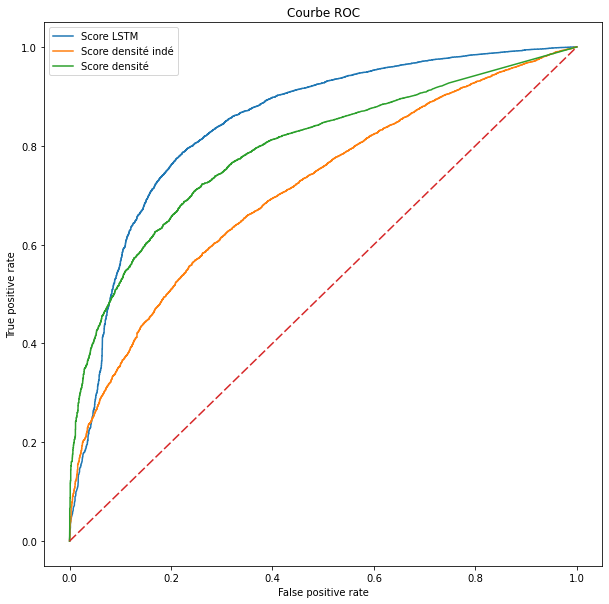

In [21]:
fpr, tpr, thresholds = metrics.roc_curve(pred.iloc[:,0], pred.iloc[:,1],pos_label=1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(pred.iloc[:,0], liste_densite,pos_label=1)
fpr3, tpr3, thresholds3 = metrics.roc_curve(pred.iloc[:,0], densite_non_inde,pos_label=1)
print('AUC RNN = {:.4f}'.format(roc_auc_score(pred.iloc[:,0], pred.iloc[:,1])))
print('AUC kde indé = {:.4f}'.format(roc_auc_score(pred.iloc[:,0], liste_densite)))
print('AUC kde non indé = {:.4f}'.format(roc_auc_score(pred.iloc[:,0],densite_non_inde )))
figure = plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)
plt.plot(np.arange(0,1.02,0.02),np.arange(0,1.02,0.02), dashes=[6, 2])
title = 'Courbe ROC'
plt.title(title) 
plt.legend(['Score LSTM','Score densité indé','Score densité'])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

### Tracé des courbes Précision-Rappel avec les 3 mesures

In [22]:
fpr, tpr, thresholds = precision_recall_curve(pred.iloc[:,0], pred.iloc[:,1],pos_label=1)
fpr2, tpr2, thresholds2 = precision_recall_curve(pred.iloc[:,0],liste_densite,pos_label=1)
fpr3, tpr3, thresholds3 = precision_recall_curve(pred.iloc[:,0],densite_non_inde,pos_label=1)

Text(0.5, 1.0, 'Précision-Rappel')

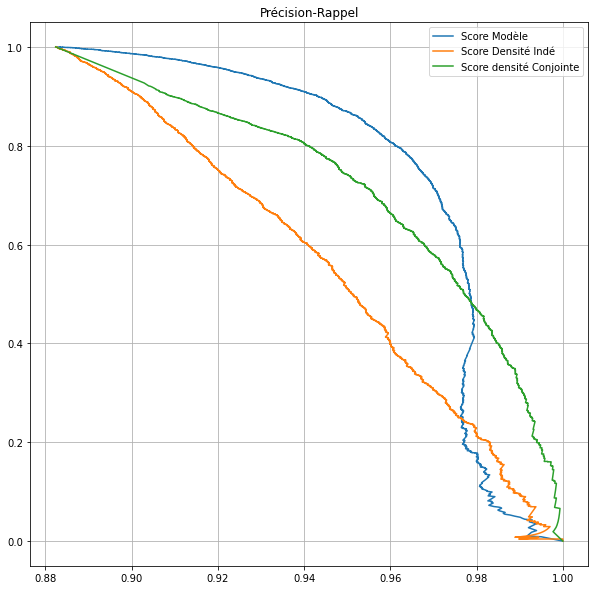

In [23]:
plt.figure(figsize = (10,10))
plt.plot(fpr,tpr)
plt.plot(fpr2,tpr2)
plt.plot(fpr3,tpr3)
plt.grid()
plt.legend(['Score Modèle','Score Densité Indé','Score densité Conjointe'])
plt.title("Précision-Rappel")

# Recherche des Clusters à partir de ces données

On va tester 3 cas :

    - 201 composantes avec la log-proba conjointe
    - 201 composantes avec la log-proba indé
    - 101 composantes avec la log-proba conjointe
    - 101 composantes avec la log-proba indé

In [24]:
X = np.array(media_test.iloc[:,5:105])
y = np.array(media_test.iloc[:,105])
X_200 = X.copy()
for i in range(100):
    X_200 = np.concatenate([X_200,dico[i].reshape(-1,1)],axis = 1)

In [25]:
clusters = ['AC','AE','NC','NE']

#####  1)

In [26]:
X_1 = np.concatenate([X_200,np.array(densite_non_inde).reshape(-1,1)],axis = 1)

In [27]:
gbc = GradientBoostingClassifier(n_estimators=500,verbose=1)
kfold = StratifiedKFold(n_splits=5) #5 split, trop long sur 10.
y_pred = cross_val_predict(gbc,X_1,y,cv=kfold,verbose=1,n_jobs = 2)
print(classification_report(y,y_pred,target_names = clusters, labels = clusters))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 1097.7min finished


              precision    recall  f1-score   support

          AC       0.85      0.93      0.89     19751
          AE       0.11      0.02      0.03       878
          NC       0.53      0.46      0.49      4699
          NE       0.14      0.03      0.04       649

    accuracy                           0.79     25977
   macro avg       0.41      0.36      0.36     25977
weighted avg       0.75      0.79      0.76     25977



##### 2)

In [28]:
X_2 = np.concatenate([X_200,np.array(liste_densite).reshape(-1,1)],axis = 1)

In [29]:
gbc = GradientBoostingClassifier(n_estimators=500,verbose=1)
kfold = StratifiedKFold(n_splits=5) #5 split, trop long sur 10.
y_pred = cross_val_predict(gbc,X_2,y,cv=kfold,verbose=1,n_jobs = 2)
print(classification_report(y,y_pred,target_names = clusters, labels = clusters))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 330.8min finished


              precision    recall  f1-score   support

          AC       0.84      0.93      0.88     19751
          AE       0.10      0.02      0.03       878
          NC       0.53      0.41      0.46      4699
          NE       0.15      0.04      0.06       649

    accuracy                           0.79     25977
   macro avg       0.40      0.35      0.36     25977
weighted avg       0.74      0.79      0.76     25977



##### 3)

In [30]:
X_3 = np.concatenate([X,np.array(densite_non_inde).reshape(-1,1)],axis = 1)

In [31]:
gbc = GradientBoostingClassifier(n_estimators=500,verbose=1)
kfold = StratifiedKFold(n_splits=5) #5 split, trop long sur 10.
y_pred = cross_val_predict(gbc,X_3,y,cv=kfold,verbose=1,n_jobs = 2)
print(classification_report(y,y_pred,target_names = clusters, labels = clusters))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 1105.6min finished


              precision    recall  f1-score   support

          AC       0.85      0.93      0.89     19751
          AE       0.12      0.02      0.03       878
          NC       0.53      0.47      0.50      4699
          NE       0.13      0.02      0.03       649

    accuracy                           0.79     25977
   macro avg       0.41      0.36      0.36     25977
weighted avg       0.75      0.79      0.77     25977

